In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest as db
from skimage.io import imread
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from scipy.stats import shapiro, normaltest, kruskal, mannwhitneyu

### To do:
1. Get a count for total # of biological reps per strain (doesn't include QC). This is to get a measurement of how hard it was to get accurate counts due to clumping
2. Generate code to filter out technical reps (duplicates) for a given screen
3. Generate plots of the current datasets

### Reading in the data:
Two individuals collected this data on seperate days, so there are two datasets. The info in these datasets include the image analysis summary and associated metadata.

In [43]:
#Data for individual one
all_dat = pd.read_csv('C:/Users/Emily/Desktop/DS/Data/DS2/DS2R1_11.csv', index_col=0)
ds_md = pd.read_csv('C:/Users/Emily/Desktop/DS/DS_MD.csv').drop([0])

In [44]:
#Data for the other individual
hf_dat = pd.read_csv('C:/Users/Emily/Desktop/DS/Data/DS2/yak_hen.csv', index_col=0)
hf_md = pd.read_csv('C:/Users/Emily/Desktop/DS/HF/HF_MD.csv', index_col=0)

### Cleaning up the data
Some of the data wasn't entered correctly into the metadata sheet during an assay. Unfortunately the data needs to be removed for the associated plates because it is unclear what the correct info is.

In [45]:
#Accounting for inconsistincies in data collection between operator 1 and 2. 
#Operator 2 captured additional null reference conditions

hf_dat = hf_dat.loc[(hf_dat['Compound'] != 'MT:MT') & 
                    (hf_dat['Compound'] != 'H20:DMSO')]
hf_dat['Compound'].unique().tolist()                    

['DI', '2-NO', 'DMSO:DMSO', 'IA', 'MT', '1-Oct', nan]

In [46]:
# Mix up in plate labeling and compuound addition on 3 plates, so ignoring that data
#plates = ['DS2_R1_7', 'DS2_R1_8', 'DS2_R1_9']
#all_dat = all_dat[~all_dat['Plate ID'].isin(plates)].dropna()
all_dat = all_dat.loc[all_dat['Strain'] != 'corrupt']
all_dat = all_dat.append(hf_dat)


In [47]:
#Inconsistencies in data entry need to be addressed
all_dat = all_dat.dropna().replace({'DMSO_DMSO': 'DMSO', '2-NO': '2NO', 
                                   '1-Oct': '1OCT', 'DMSO:DMSO': 'DMSO', 'DMSO_MT':'MT' })

In [48]:
#passed = all_dat.loc[all_dat['Passes QC'] == 'Y']
strains = all_dat['Strain'].unique().tolist()
compounds = all_dat['Compound'].unique().tolist()
compounds

['DI', '2NO', '1OCT', 'DMSO', 'MT', 'IA']

In [49]:
#Making sure the metadata sheets between operators has consistent headers

ds_md = ds_md[['Plate ID', 'Compound Well A','Compound Well B', 'Compound Well C', 'Compound Well D', 
              'Strain Well A', 'Strain Well B', 'Strain Well C', 'Strain Well D', 'Image ID', 'Scanner Slot:']]
hf_md = hf_md[['Plate ID', 'Compound Well A','Compound Well B', 'Compound Well C', 'Compound Well D', 
              'Strain Well A', 'Strain Well B', 'Strain Well C', 'Strain Well D', 'Image ID', 'Scanner Slot:']]
all_md = ds_md.append(hf_md)

### Aggregating location data based on analysis type
We can perform a between strains or a between compounds analysis. To do that we need to aggregate the worm locations accordingly.

In [50]:
# Function to aggregate worm locations based for a between strains analysis (Multiple strain responses to 1 compound)
def get_worm_locs_c(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound']
    xs = temp['X']

    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        #print(compound + ' ' + str(len(result_dict[compound])))
        result_dict[compound].reset_index(inplace=True, drop=True)
        #print(result_dict.keys())
        
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs

    return result_dict

# Function to aggregate worm locations based for a between compounds analysis (1 strain against many compounds)
def get_worm_locs_s(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    strain = row['Strain']
    xs = temp['X']

    if strain in result_dict:
        result_dict[strain] = result_dict[strain].append(xs)
        #print(compound + ' ' + str(len(result_dict[compound])))
        result_dict[strain].reset_index(inplace=True, drop=True)
        #print(result_dict.keys())
        
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[strain]=xs

    return result_dict

In [51]:
# File path to the location data
fpath = plb.Path('C:/Users/Emily/Desktop/DS/Data/DS2/')

In [52]:
# An ordered list to pass to the dataviz package. Control condition needs to appear first
c_ordr = ['DMSO', 'MT', 'IA', 'DI', '2NO', '1OCT']
# A dictionary to assign colors to conditions in the plots
color_dict = {'DMSO':'#5e4fa2', 'MT':'#5e4fa2', 'IA':'#66c2a5', 'DI':'#66c2a5', '2NO':'#fdae61', '1OCT':'#fdae61'}

### Plotting the data for between strains analysis
This code block will check to see if each replicate passes QC. If it doesn't then the data is ignored. 

At the beginning of our screens we were collecting technical replicates for each condition. This proved to be costly in terms of time and resources so we decided to discontinue technical reps for the remaining screens. As a result we developed the code to plot only the first technical replicate that passes QC. 

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


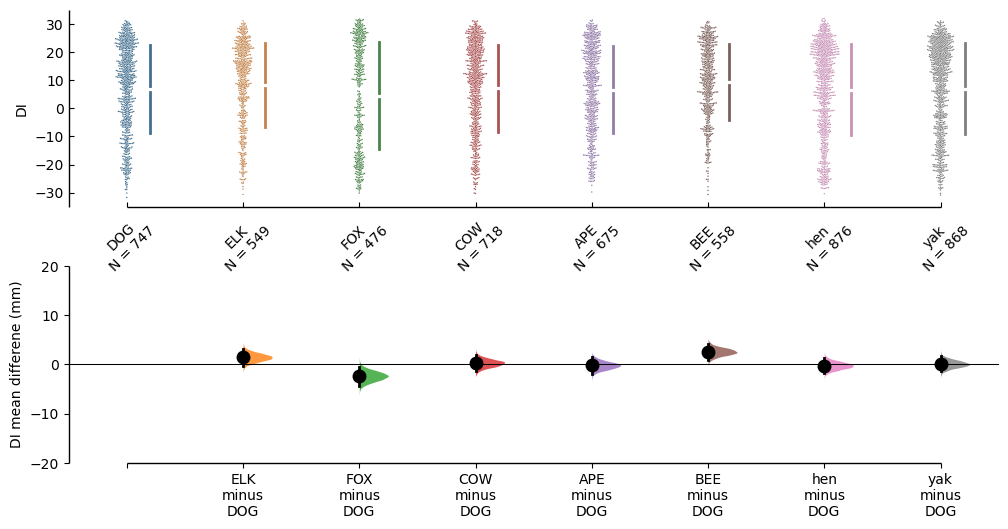

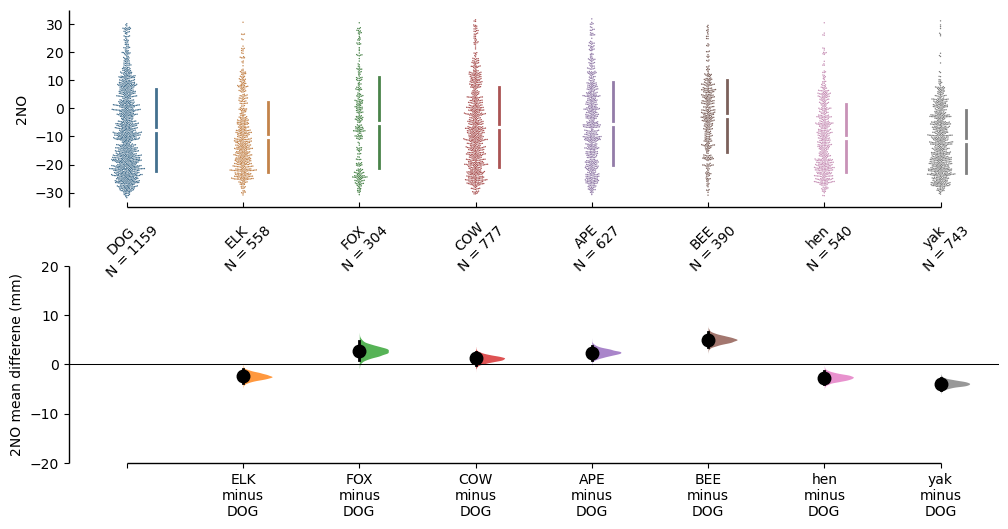

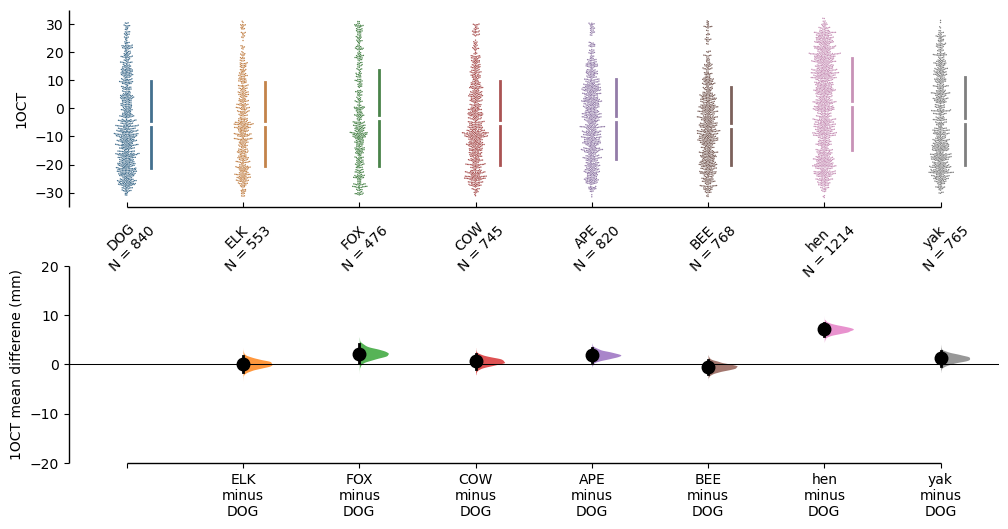

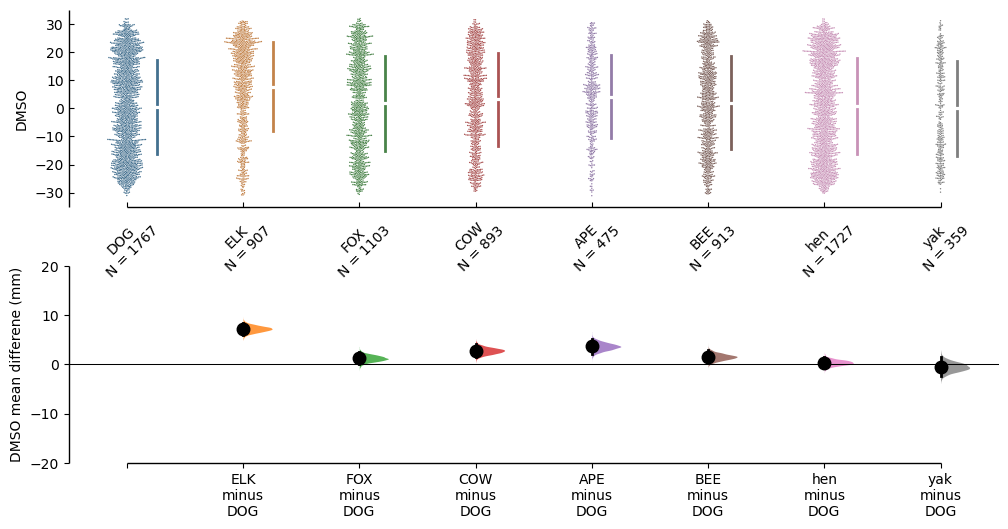

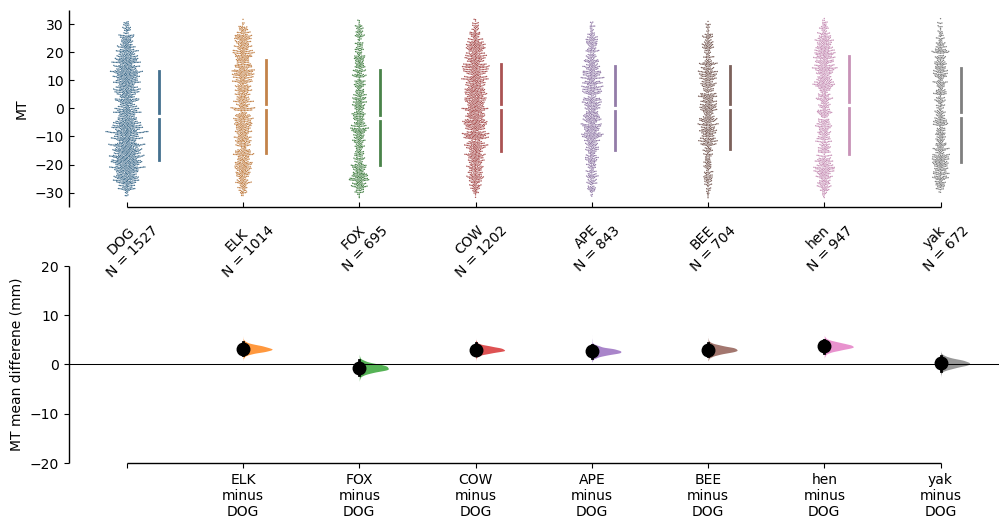

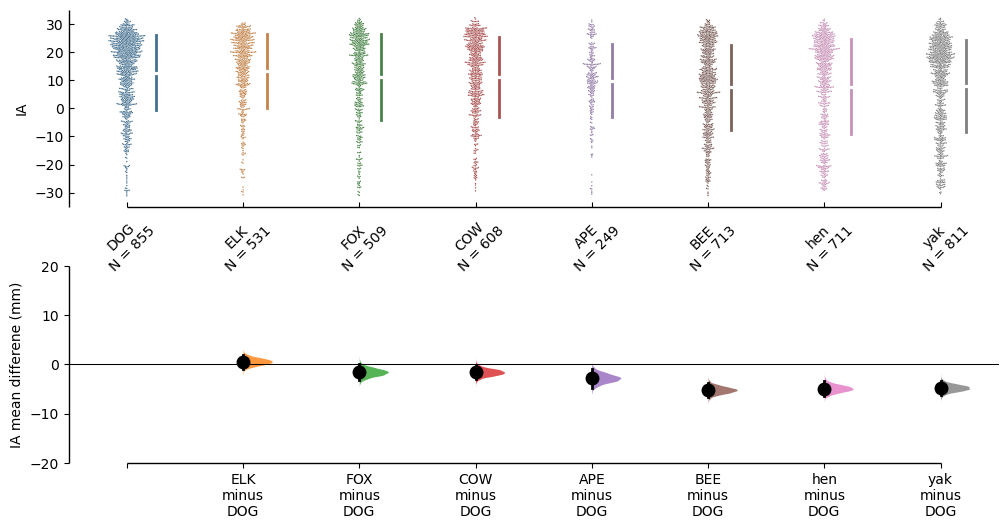

In [54]:
#An ordered list of blindend strain names. Control condition (N2) is at the first item
s_ordr = ['DOG', 'ELK', 'FOX', 'COW', 'APE', 'BEE', 'hen', 'yak']
#dog = passed.loc[passed['Strain']=='DOG']
s_pnum = (0,0)
for c in compounds:
    h = {}
    for s in strains:
        data = all_dat.loc[(all_dat['Compound'] == c) & (all_dat['Strain'] == s)]
        for index, row in data.iterrows():
            if row['Passes QC'] == 'Y':
#                 if s_pnum != (s, row['Plate ID']):
#                     s_pnum = (s, row['Plate ID'])
                hold = get_worm_locs_s(row, fpath, h)
#                 else:
#                     continue
            elif row['Passes QC'] == 'N':
                continue
        #hold = data.apply(lambda row: get_worm_locs(row, fpath, h), axis=1)
    pooled = pd.DataFrame.from_dict(hold)

    #pooled.to_csv('C:/Users/Emily/Desktop/DS/Data/DS2/' + c + '_xs.csv')
    mm = 25.4
    # 1200 pixels per 25.4mm
    px_mm = 1200/mm
    #The following transforms the worm location data so that it is respective to the start zone
    # The start zone is at the center of the image; Start Zone = 0mm
    #Worms with positive values are closer to the compound, negative values are away from the compound
    mm_df = pooled.apply(lambda x: -(x/px_mm)+32.5)
    db_obj = db.load(mm_df, idx=(s_ordr))
    mm_plot = db_obj.mean_diff.plot(raw_marker_size=1, swarm_label = c, 
                                        contrast_label= c + " mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35))

    #Accessing plot axes to control plot asthetics
    rawswarm_axes = mm_plot.axes[0]
    contrast_axes = mm_plot.axes[1]

    rawswarm_axes.yaxis.set_tick_params(tickdir='in')
    rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)
    plt.rcParams['svg.fonttype'] = 'none'
    #plt.savefig('C:/Users/Emily/Desktop/DS/Figs/' + c + '_N2ref.png')

### Plotting the between compounds analysis.
This code also filters out data that does not pass QC and ignores technical reps

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Program

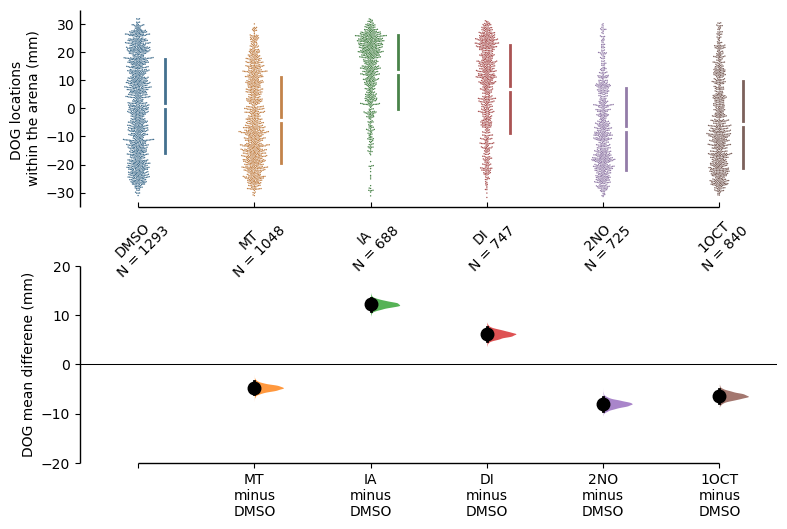

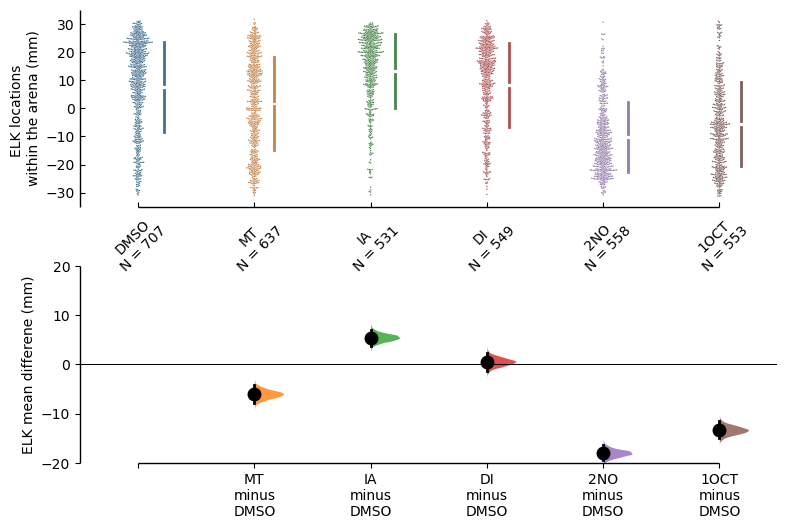

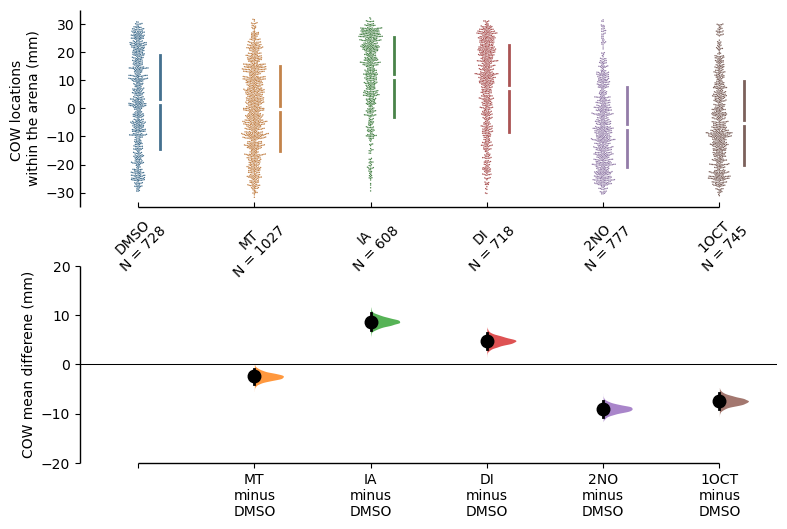

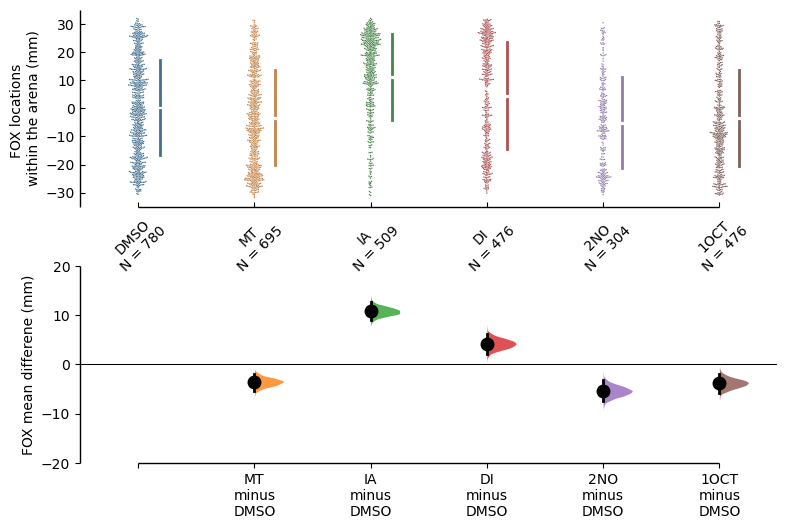

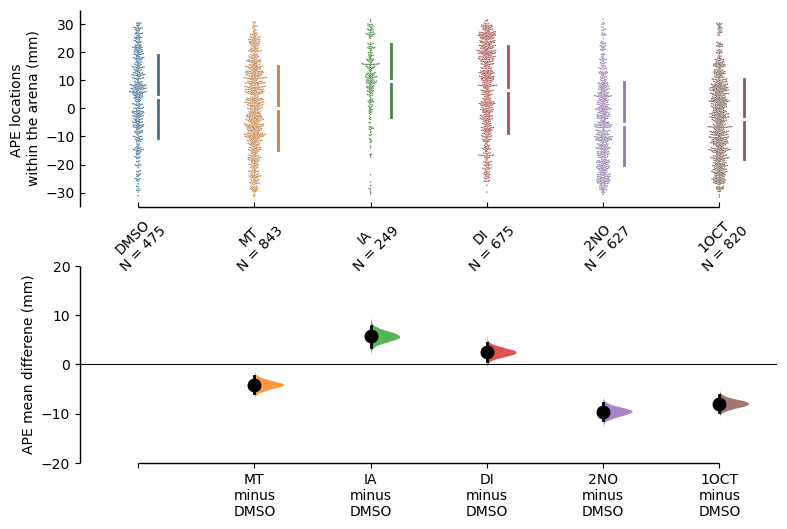

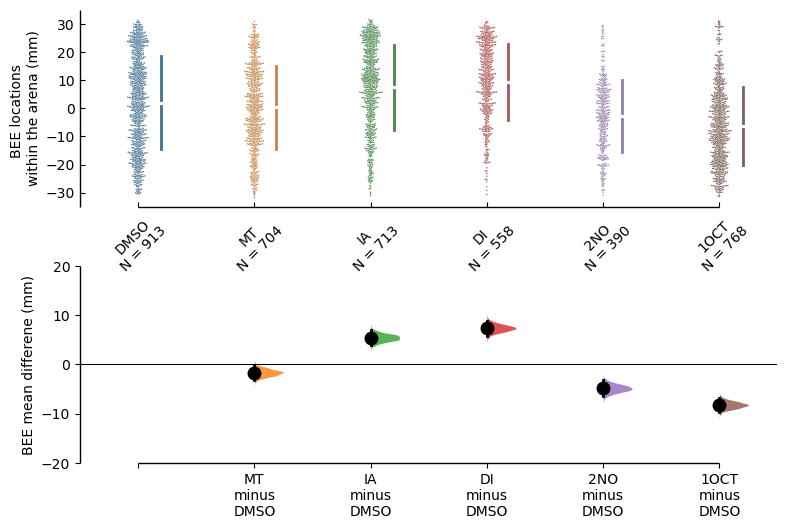

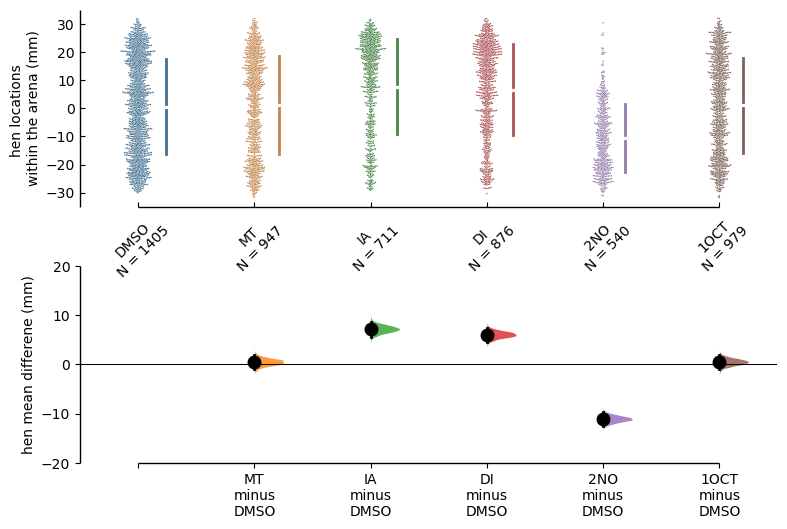

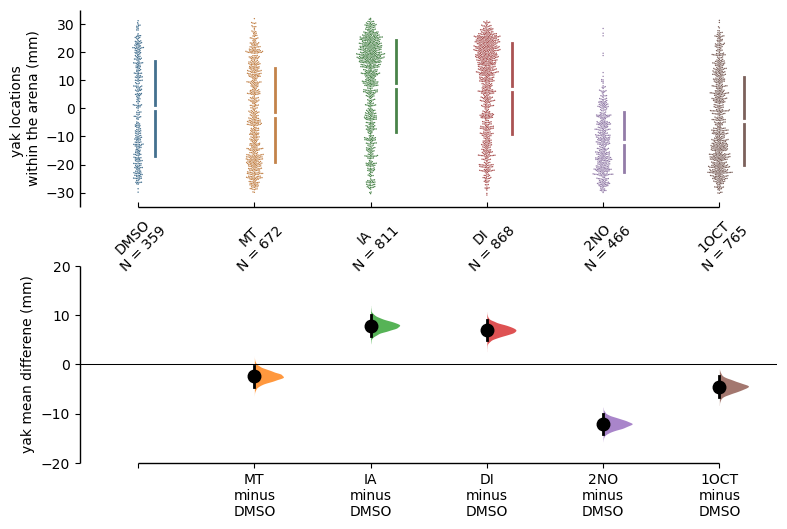

In [41]:

for s in strains:
    h = {}
    for c in compounds:
        data = all_dat.loc[(all_dat['Compound'] == c) & (all_dat['Strain'] == s)]
        for index, row in data.iterrows():
            if row['Passes QC'] == 'Y':
                if s_pnum != (s, row['Plate ID']):
                    s_pnum = (s, row['Plate ID'])
                    hold = get_worm_locs_c(row, fpath, h)
                else:
                    continue
            elif row['Passes QC'] == 'N':
                continue
            #hold = get_worm_locs_c(row, fpath, h)
        #hold = data.apply(lambda row: get_worm_locs(row, fpath, h), axis=1)
    pooled = pd.DataFrame.from_dict(hold)
    #pooled.to_csv('C:/Users/Emily/Desktop/DS/Data/DS2/' + s + '_xs.csv')
    mm = 25.4
    # 1200 pixels per 25.4mm
    px_mm = 1200/mm
    #The following transforms the worm location data so that it is respective to the start zone
    # The start zone is at the center of the image; Start Zone = 0mm
    #Worms with positive values are closer to the compound, negative values are away from the compound
    mm_df = pooled.apply(lambda x: -(x/px_mm)+32.5)
    db_obj = db.load(mm_df, idx=(c_ordr))
    mm_plot = db_obj.mean_diff.plot(raw_marker_size=1, swarm_label = s + ' locations \nwithin the arena (mm)', 
                                        contrast_label= s + " mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35))

    #Accessing plot axes to control plot asthetics
    rawswarm_axes = mm_plot.axes[0]
    contrast_axes = mm_plot.axes[1]

    rawswarm_axes.yaxis.set_tick_params(tickdir='in')
    rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('C:/Users/Emily/Desktop/DS/' + s + '_nullref.png')
    

### Analysis of attempts vs total QC passd for each strain

In [8]:
a = all_dat.groupby(['Compound', 'Strain'])['WellNo'].count().reset_index(name="Total_attempts")

In [9]:
p = a.groupby(['Compound', 'Strain'])['WellNo'].count().reset_index(name='QC_passed')

In [10]:
c = pd.merge(a, p, on=['Compound', 'Strain'], how='inner')
c['Failed'] = c.apply(lambda x: x['Total_attempts'] - x['QC_passed'], axis=1)


In [11]:
c.groupby('Strain').sum()

,Total_attempts,QC_passed,Failed
Strain,,,
APE,23,15,8
BEE,24,16,8
COW,42,21,21
DOG,57,31,26
ELK,58,21,37
FOX,50,18,32
